<a href="https://colab.research.google.com/github/rsadaphule/jhu-aaml/blob/main/Module03_Hyperparameter_Tuning_sadaphule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 03 - Hyperparameter Tuning
# JHU Course EN.705742.8VL.FA23
## Student: Ravindra Sadaphule

### Notes
* This notebook runs on Google Colab ENvironement
* All data  files are read from Google Drive rom path TRAIN_FILE_FOLDER
* The notebook ran on GPU A100 with high RAM

In [1]:
from google.colab import drive; drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72
from IPython.display import display
import numpy as np
import pandas as pd
from random import random
import sys

In [3]:
TRAIN_FILE_FOLDER = '/content/drive/My Drive/JHU/AAML/Assignments/data/'


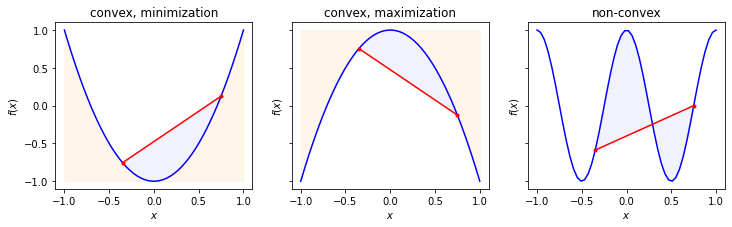

In [4]:
# plot
def plotx(_ax, _x, _x1, _x2, _func, _title, region=0):
    _y, _y1, _y2 = _func(_x), _func(_x1), _func(_x2)
    _ax.plot(_x,_y, c='b')
    _ax.plot([_x1,_x2], [_y1,_y2], c='r', marker = '.')
    _ax.fill_between(np.linspace(_x1,_x2), _func(np.linspace(_x1,_x2)), np.linspace(_y1,_y2), color='lavender', alpha=0.5)
    if region == 0:  # minimization
        _ax.fill_between(_x, [min(_y)]*len(_x), _y, color='papayawhip', alpha=0.5)
    elif region == 1:  # maximization
        _ax.fill_between(_x, _y, [max(_y)]*len(_x), color='papayawhip', alpha=0.5)
    _ax.set(xlabel='$x$', ylabel='$f(x)$', title=_title)

def show_convex():
    _, ax_ = plt.subplots(1, 3, figsize=(12, 3), sharey='all')
    # x and f(x)
    x, x1, x2 = np.linspace(-1,1), -0.35, 0.75

    plotx(ax_[0], x, x1, x2, lambda _: 2*_**2-1, 'convex, minimization', region=0)
    plotx(ax_[1], x, x1, x2, lambda _: -2*(_**2)+1, 'convex, maximization', region=1)
    plotx(ax_[2], x, x1, x2, lambda _: np.cos(2*np.pi*_), 'non-convex', region=2)
    plt.show()

show_convex()

In [5]:
!pip install pyswarms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.6 MB/s eta 0:00:00


In [6]:
!pip install Bayesian-optimization

In [7]:
# read disinformation dataset, Tf-Idf preprocessed
df = pd.read_csv(TRAIN_FILE_FOLDER + 'disinformation.csv')
display(df.head())

dataX = df.loc[:, df.columns != 'class'].values
datay = df.loc[:, df.columns == 'class'].values.ravel()

,f01,f02,f03,f04,f05,f06,f07,f08,f09,f10,...,f92,f93,f94,f95,f96,f97,f98,f99,f100,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.78201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier

def run_classifier(_clf, blog=False):
    global dataX, datay, pso_log
    _X, _y = dataX, datay
    tpr, fpr, acc = [], [], []
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    for tr_i, ts_i in kf.split(_X, _y):
        _clf.fit(_X[tr_i], _y[tr_i])
        y_pred = _clf.predict(_X[ts_i])
        acc += [accuracy_score(_y[ts_i], y_pred)]
        tn, fp, fn, tp = confusion_matrix(_y[ts_i], y_pred, labels=[1,0]).ravel()
        tpr += [tp/(tp+fn)]  # Probability
        fpr += [fp/(fp+tn)]  # False alarm
    tpr, fpr = np.mean(tpr), np.mean(fpr)
    if blog:
        pso_log += [(tpr, fpr)]  # to log progress or OP
    return np.mean(acc), np.std(acc), tpr, fpr

In [9]:
# Hyperparameters, alphabetical
N_ESTIM= (20,100)
MAX_DEP= (2,7)
MAX_FEA= (3,20)

In [10]:
%%time

# Grid Search

def run_params_randomforest():
    Tpr, Fpr, Acc, Std = [], [], [], []
    # grid search
    for ne in np.linspace(N_ESTIM[0],N_ESTIM[1], num=3, dtype=int):
        for md in np.linspace(MAX_DEP[0],MAX_DEP[1], num=3, dtype=int):
            for mf in np.linspace(MAX_FEA[0],MAX_FEA[1], num=3, dtype=int):
                acc, std, tpr, fpr = run_classifier(  # classifier
                    RandomForestClassifier(n_estimators=ne, max_depth=md, max_features=mf, n_jobs=-1))
                Acc += [acc]; Std += [std]; Tpr += [tpr]; Fpr += [fpr]
                # debug
                # print(f'RF acc={acc:.2f} {chr(177)}{std:.3f}')
                sys.stderr.write(f'\rRF acc={acc:.2f} {chr(177)}{std:.3f}   params=({ne:3d},{md:3d},{mf:3d})')
                sys.stderr.flush()
    return Tpr, Fpr, Acc, Std

Tpr1, Fpr1, Acc1, Std1 = run_params_randomforest()

RF acc=0.80 ±0.006   params=(100,  7, 20)

CPU times: user 5min 21s, sys: 14.4 s, total: 5min 35s
Wall time: 1min 19s


In [11]:
# PSO

def avg(_x):
    return (_x[0]+_x[1])/2.

def costf_pso(_X):  # PSO minimizes
    """
    _X is the list of particles called by the pyswarms library
    (S, M) = _X.shape
    S number of particles
    M number of dimensions, i.e. number of independent variables, hyperparameters
    """
    def costf(_pd, _pf):
        return 5*(1.-_pd)+_pf

    S = _X.shape[0]  # number of particles
    # each particle cost function is evaluated
    costs = np.ones((S,), dtype=float)

    for i in range(S):
        hp = np.array(_X[i], int)  # hyperparameters are integers
        clf = RandomForestClassifier(n_estimators=hp[0], max_depth=hp[1], max_features=hp[2], n_jobs=-1)
        acc, std, tpr, fpr = run_classifier(clf, blog=True)
        costs[i] = costf(tpr, fpr)

    return costs

In [12]:
from pyswarms.single import GeneralOptimizerPSO
from pyswarms.backend.topology import Star, Ring, VonNeumann, Random, Pyramid

N_PARTICLES= 7  # number of particles

N_HYPERPARAMS= 3  # number of hyperparameters

# Swarm parameters
# c1:cognitive parameter, c2:social parameter, w:inertia parameter, k:num neighbors, p:L1 or L2
PYSWARM_OPTS= {'c1': 0.5, 'c2': 0.5, 'w': 0.7, 'k': 3, 'p': 2}

# Constraints are alphabetical
Constraints = (np.array([N_ESTIM[0], MAX_DEP[0], MAX_FEA[0]], dtype=float),
               np.array([N_ESTIM[1], MAX_DEP[1], MAX_FEA[1]], dtype=float))

init_pos = np.array([avg(N_ESTIM), avg(MAX_DEP), avg(MAX_FEA)])  # middles of the contraint ranges
Init_pos= np.array([init_pos+1-2*random() for _ in range(N_PARTICLES)])

PSO_ITERS_N= 10  # number of iterations

optimizer = GeneralOptimizerPSO(  # GeneralOptimizerPSO
    n_particles= N_PARTICLES,
    dimensions= N_HYPERPARAMS,
    options= PYSWARM_OPTS,
    topology= Star(),
    bounds= Constraints,
    init_pos= Init_pos,
    )

In [13]:
%%time

pso_log = []  # collect Pd Pf

# run the optimizer
pso_cost, pso_pos = optimizer.optimize(costf_pso, iters=PSO_ITERS_N)


2023-09-21 23:57:06,742 - pyswarms.single.general_optimizer - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.7, 'k': 3, 'p': 2}
pyswarms.single.general_optimizer: 100%|██████████|10/10, best_cost=0.519
2023-09-22 00:00:39,295 - pyswarms.single.general_optimizer - INFO - Optimization finished | best cost: 0.5194191691328812, best pos: [61.18476419  5.40726512 12.53337115]


CPU times: user 15min 49s, sys: 38 s, total: 16min 27s
Wall time: 3min 32s


In [14]:
# PSO best solution
print(f'cost= {pso_cost:.3f}')
pso_op_params = [int(pso_pos[_]) for _ in range(N_HYPERPARAMS)]
print(f'OP params= {pso_op_params}')

# best OP
_, _, pso_tpr, pso_fpr = run_classifier(
    RandomForestClassifier(n_estimators=pso_op_params[0],
                           max_depth=pso_op_params[1], max_features=pso_op_params[2], n_jobs=-1))

Fpr2, Tpr2 = [_[1] for _ in pso_log], [_[0] for _ in pso_log]
Std2 = 0.02*np.ones((len(Tpr2),), dtype=float)

cost= 0.519
OP params= [61, 5, 12]


In [15]:
# Bayesian Optimization

from bayes_opt import BayesianOptimization

# constraints
pbounds = {'ne':N_ESTIM, 'md':MAX_DEP, 'mf':MAX_FEA}

def costf_bop(ne, md, mf):  # Bayesian Op maximizes
    cost = costf_pso(np.array([ne, md, mf]).reshape(-1,3))
    return -cost[0]

boptim = BayesianOptimization(
    f= costf_bop,
    pbounds= pbounds,
    random_state=0,
)

In [16]:
%%time

pso_log = []  # collect Pd Pf

# run the optimizer
boptim.maximize(init_points=3, n_iter=PSO_ITERS_N)

|   iter    |  target   |    md     |    mf     |    ne     |
-------------------------------------------------------------
| 1         | -0.5384   | 4.744     | 15.16     | 68.22     |
| 2         | -1.243    | 4.724     | 10.2      | 71.67     |
| 3         | -0.5431   | 4.188     | 18.16     | 97.09     |
| 4         | -0.5241   | 5.346     | 15.08     | 87.71     |
| 5         | -0.5414   | 3.151     | 19.28     | 50.66     |
| 6         | -0.8859   | 4.706     | 12.4      | 78.61     |
| 7         | -3.581    | 2.977     | 7.682     | 26.91     |
| 8         | -4.458    | 2.0       | 3.0       | 100.0     |
| 9         | -2.121    | 7.0       | 3.0       | 53.11     |
| 10        | -1.662    | 2.0       | 20.0      | 81.66     |
| 11        | -0.5202   | 7.0       | 20.0      | 59.9      |
| 12        | -0.5236   | 7.0       | 20.0      | 40.8      |
| 13        | -0.5222   | 6.775     | 19.28     | 61.28     |
CPU times: user 3min 19s, sys: 19.9 s, total: 3min 39s
Wall time: 45.3

In [17]:
# Bayesian Op best solution
print(f"cost= {boptim.max['target']:.3f}")
bop_op_params = [int(boptim.max['params']['ne']), int(boptim.max['params']['md']), int(boptim.max['params']['mf'])]
print(f"OP params= {bop_op_params}")

# best OP
_, _, bop_tpr, bop_fpr = run_classifier(
    RandomForestClassifier(n_estimators=bop_op_params[0],
                           max_depth=bop_op_params[1], max_features=bop_op_params[2], n_jobs=-1))

Fpr3, Tpr3 = [_[1] for _ in pso_log], [_[0] for _ in pso_log]
Std3 = 0.02*np.ones((len(Tpr3),), dtype=float)

cost= -0.520
OP params= [59, 7, 20]


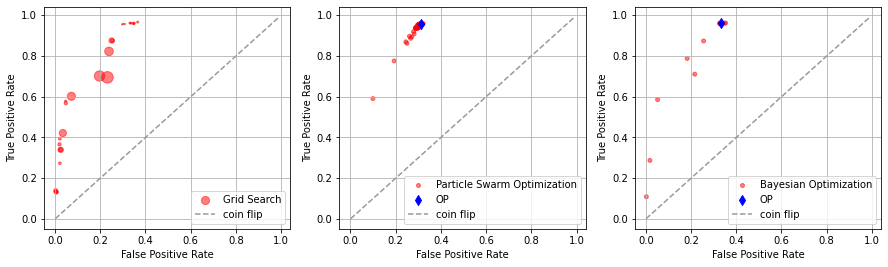

In [18]:
# Size of the marker shows the error variance for grid search
COEF = 200
Std10 = (COEF*np.array(Std1))**2
Std20 = (COEF*np.array(Std2))**2
Std30 = (COEF*np.array(Std3))**2

def plotr(_ax, _fpr, _tpr, _std0, _label, op=None):
    _ax.scatter(_fpr, _tpr, s=_std0, marker='o', c='r', label=_label, alpha=0.5)
    if op is not None:
        _ax.scatter(op[0], op[1], s=50, marker='d', c='b', label='OP')
    _ax.plot(np.arange(0.001,1,0.01), np.arange(0.001,1,0.01), linestyle='--', color=(0.6, 0.6, 0.6), label='coin flip')
    _ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    _ax.grid()
    _ax.legend()

_, ax = plt.subplots(1, 3, figsize=(15,4), dpi=72)
ax = ax.flatten()

plotr(ax[0], Fpr1, Tpr1, Std10, 'Grid Search')
plotr(ax[1], Fpr2, Tpr2, Std20, 'Particle Swarm Optimization', op=(pso_fpr,pso_tpr))
plotr(ax[2], Fpr3, Tpr3, Std30, 'Bayesian Optimization', op=(bop_fpr,bop_tpr))

plt.show()

Exercises
Exercise 1. Comment about the OPs close to (0.30, 0.95) coordinate in Particle Swarm Optimization ROC.

Ans - OP (Optimal Point) represents a set of best parametsrs that yields best pefroamcne according to objective function. The coordinates OP(0.30, 0.95) on the ROC (Receiver Operating Characteristic) curve represent a False Positive Rate (FPR) of 0.30 and a True Positive Rate (TPR) of 0.95 and this is best perfroance we can get with PSO. A TPR of 0.95 means that the classifier correctly identifies 95% of the positive instances. This is a good sign as it indicates that the classifier has a high sensitivity and can correctly detect most of the positive cases. An FPR of 0.30 means that 30% of the negative instances are incorrectly classified as positive. This indicates a certain level of false alarms where the classifier mistakenly identifies negative cases as positive. Overall it suggests that the hyperparameters optimized by PSO lead to a model with high sensitivity but at the cost of a moderate false alarm rate. The closeness of the OPs to this coordinate indicates that the PSO might be prioritizing maximizing the TPR, even if it results in a higher FPR. This could be due to the cost function used in the PSO optimization, which might be giving more weight to TPR. In some applications, having a high TPR might be crucial, even if it comes at the expense of a moderate FPR. For instance, in medical diagnostics, it might be more acceptable to have some false alarms (which can be further investigated) rather than missing a potential positive case. If reducing the FPR is a priority, one might consider adjusting the cost function in the PSO to penalize higher FPRs more heavily.





Exercise 2. Change the acquisition function in Bayesian optimization.

Ans - the acquisition function is a important t guides the search for the next sampling point (or set of hyperparameters, in the context of hyperparameter tuning). Different acquisition functions have different strategies and can lead to different results.

Here are few examples of acquistsion function:

Probability of Improvement (PI): This function selects the next point where there's the highest probability of observing an improvement over the current best value.

Expected Improvement (EI): This function selects the point that maximizes the expected improvement over the current best value.

To change the acquisition function in Bayesian Optimization using the bayes_opt library (as in the code you provided), let's modify the BayesianOptimization object's maximize method by setting the acq parameter.




In [19]:
from bayes_opt import BayesianOptimization
from bayes_opt.util import UtilityFunction

# Define the acquisition function
utility = UtilityFunction(kind="ei", kappa=2.576, xi=0.0)

# Use the acquisition function in the maximize method
boptim.maximize(init_points=3, n_iter=PSO_ITERS_N, acquisition_function=utility)


|   iter    |  target   |    md     |    mf     |    ne     |
-------------------------------------------------------------
| 14        | -0.5428   | 3.917     | 16.46     | 62.31     |
| 15        | -0.5319   | 4.84      | 18.74     | 25.68     |
| 16        | -4.339    | 2.436     | 3.344     | 86.61     |
| 17        | -0.5115   | 7.0       | 19.95     | 92.24     |
| 18        | -0.5239   | 7.0       | 20.0      | 30.51     |
| 19        | -0.52     | 7.0       | 20.0      | 20.0      |
| 20        | -0.5244   | 7.0       | 20.0      | 24.97     |
| 21        | -1.833    | 2.0       | 20.0      | 23.18     |
| 22        | -1.449    | 2.921     | 19.87     | 65.3      |
| 23        | -0.5164   | 7.0       | 13.99     | 62.87     |
| 24        | -0.5228   | 6.382     | 16.71     | 54.92     |
| 25        | -0.5225   | 7.0       | 20.0      | 47.38     |
| 26        | -1.451    | 2.0       | 20.0      | 42.94     |


Exercise 3. Implement an early stopping method in the fit method of a neural network implementation.

And- Early stopping is a regularization technique used to prevent overfitting in neural networks and other machine learning models.

In [20]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical


# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(dataX, datay, test_size=0.2, random_state=42)

# Convert target to one-hot encoding for neural network
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

# Define a simple neural network model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(dataX.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))  # Assuming binary classification

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Implementing early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
1000/1000 [==============================] - 9s 3ms/step - loss: 0.3439 - accuracy: 0.8366 - val_loss: 0.3083 - val_accuracy: 0.8543
Epoch 2/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3095 - accuracy: 0.8564 - val_loss: 0.2990 - val_accuracy: 0.8657
Epoch 3/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3023 - accuracy: 0.8580 - val_loss: 0.2998 - val_accuracy: 0.8594
Epoch 4/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2976 - accuracy: 0.8620 - val_loss: 0.3014 - val_accuracy: 0.8628
Epoch 5/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2922 - accuracy: 0.8640 - val_loss: 0.2969 - val_accuracy: 0.8652
Epoch 6/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2868 - accuracy: 0.8665 - val_loss: 0.2981 - val_accuracy: 0.8619
Epoch 7/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2823 - accuracy: 0.8693 - val_loss: 0.2971 - val_ac

Assignment 03:
1. [10 pts] Conduct a feature exploration to see that this dataset does not have a particular
class or label intended but rather it consists of information collected by the bank. Which
variable should be picked as the dependent variable?



In [21]:
# read disinformation dataset, Tf-Idf preprocessed
df = pd.read_csv(TRAIN_FILE_FOLDER + 'credit_risk_dataset.csv')
display(df.head())

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


Ans -

Lets look at each column to understand what it means
* person_age: Age of the person. This is typically an independent variable.
* person_income: Income of the person. This can be both an independent variable or a dependent variable, depending on the context.
* person_home_ownership: Type of home ownership (e.g., RENT, OWN, MORTGAGE). This is typically an independent variable.
* person_emp_length: Length of employment in years. This is typically an independent variable.
* loan_intent: Purpose of the loan (e.g., PERSONAL, EDUCATION, MEDICAL). This is typically an independent variable.
* loan_grade: Grade of the loan (e.g., A, B, C, D). This can be both an independent variable or a dependent variable. If it's a grade assigned based on the riskiness of the loan, it can be used as a dependent variable.
* loan_amnt: Amount of the loan. This is typically an independent variable.
* loan_int_rate: Interest rate of the loan. This can be both an independent variable or a dependent variable. Higher-risk loans might have higher interest rates.
* loan_status: Status of the loan (e.g., 0 might indicate no default, 1 might indicate default). This is a strong candidate for a dependent variable, especially in a credit risk context.
* loan_percent_income: The ratio of the loan amount to the person's income. This is typically an independent variable.
* cb_person_default_on_file: Indicates if the person has defaulted in the past (e.g., Y for Yes, N for No). This can be both an independent variable or a dependent variable.
* cb_person_cred_hist_length: Length of the person's credit history. This is typically an independent variable.

Our goal is to see what columns could become a label that we can predict. Here are potential candidates.

* loan_status: This directly indicates whether a loan has defaulted or not, making it a prime candidate for a binary classification problem.
* loan_grade: If this grade is assigned based on the riskiness of the loan, it can be used as a dependent variable for a multi-class classification or regression problem.
* loan_int_rate: If you're interested in predicting the interest rate based on other features, this can be your dependent variable for a regression problem.
* cb_person_default_on_file: This can be used as a dependent variable if you're interested in predicting whether a person has defaulted in the past based on other features.

Since the data is about credit risk analysis, the most promising dependent variable would be loan_status. Predicting loan default (binary classification: default or no default) is a classic problem in credit risk modeling.

2. [20 pts] Follow machine learning practices and explain the relations between the variables.
Ans - There are various ways to understand relationships among variables.
* Correlation Matrix : A correlation matrix can help identify linear relationships between numerical variables.
* Scatter Plots:
Scatter plots can help visualize the relationship between two numerical variables.

<ipython-input-22-9e6ba56c314d>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


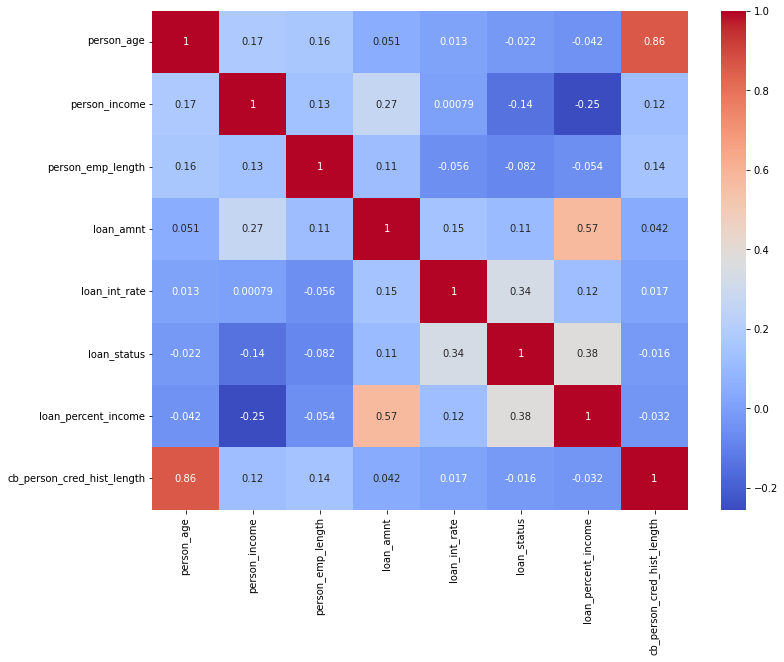

In [22]:
#Correlation Matrix
import seaborn as sns
correlation_matrix = df.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


Analysis: When features are coorelated, the value will be closer to 1 or -1. As you can see from above person_age and cb_person_cred_hist_length are highly correelated for obvious reasons. Features that are highly coorelated can be deduped. We can just keep one of them.

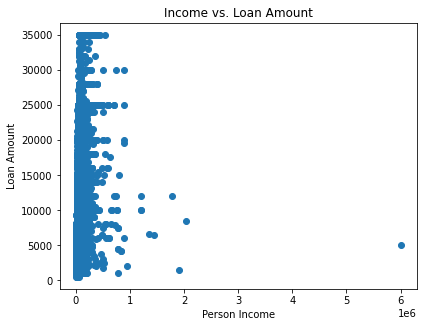

In [23]:
# Scatter Plot
plt.scatter(df['person_income'], df['loan_amnt'])
plt.xlabel('Person Income')
plt.ylabel('Loan Amount')
plt.title('Income vs. Loan Amount')
plt.show()


Analysis: As you can see Most the loans are for the people who earn below 100K.

3. [20 pts] Pick three classifiers and report their performance on this dataset using cross
validation of your choosing size.

Ans-  I'll choose the following classifiers:

* Logistic Regression: A simple linear classifier that's often used as a baseline.
* Random Forest: An ensemble method that can capture complex relationships in the data.
* SVM: SVMs are powerful classifiers that work by finding the hyperplane that best divides a dataset into classes


In [24]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

# Preprocessing
# Encoding categorical variables
label_encoders = {}
for column in ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le


# Handling missing values
imputer = SimpleImputer(strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)


# Scaling numerical variables
scaler = StandardScaler()
df[['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']] = scaler.fit_transform(df[['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']])

# Splitting data into features and target
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM (RBF Kernel)": SVC(kernel='rbf', probability=True)
}

# Cross-validation and performance evaluation
cv = StratifiedKFold(n_splits=5)

for name, clf in classifiers.items():
    tprs, fprs = [], []
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)

        tprs.append(tpr)
        fprs.append(fpr)

    print(f"{name}: TPR: {sum(tprs)/len(tprs):.4f}, FPR: {sum(fprs)/len(fprs):.4f}")






Logistic Regression: TPR: 0.4443, FPR: 0.0479
Random Forest: TPR: 0.6901, FPR: 0.0156
SVM (RBF Kernel): TPR: 0.5495, FPR: 0.0313


4. [20 pts] Using those picked classifiers and a range of 3 (or 2 if the classifier is not suitable)
of their hyperparameters, determine best models by maximizing their performance via
hyperparameter optimization.

Ans - we can use Grid Search or Random Search. Here, I'll be using Grid Search with the GridSearchCV method from scikit-learn.
For each classifier, we'll pick a range of 3 (or 2, if more suitable) hyperparameters and their potential values. Then, we'll search for the best combination of hyperparameters that maximizes the performance (in terms of TPR and FPR).

Here's how we can do it:

* Logistic Regression: We'll optimize the regularization strength (C) and the type of regularization (penalty).
* Random Forest: We'll optimize the number of trees (n_estimators), the maximum depth of the trees (max_depth), and the minimum samples required to split an internal node (min_samples_split).
* SVM (RBF Kernel): We'll optimize the regularization parameter (C), the kernel coefficient (gamma), and the class weight (class_weight).


In [25]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer

# Custom scorer for TPR and FPR
'''
def custom_scorer(clf, X, y_true):
    y_pred = clf.predict(X)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr - fpr  # We want to maximize TPR and minimize FPR
'''


def custom_scorer(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr - fpr  # We want to maximize TPR and minimize FPR

scorer = make_scorer(custom_scorer, greater_is_better=True)


# Preprocessing
# Encoding categorical variables
label_encoders = {}
for column in ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le


# Handling missing values
imputer = SimpleImputer(strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)


# Scaling numerical variables
scaler = StandardScaler()
df[['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']] = scaler.fit_transform(df[['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']])

# Splitting data into features and target
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Hyperparameters and their potential values
param_grids = {
    "Logistic Regression": {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    "Random Forest": {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    "SVM (RBF Kernel)": {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'class_weight': [None, 'balanced']
    }
}

best_models = {}

for name, clf in classifiers.items():
    grid_search = GridSearchCV(clf, param_grids[name], scoring=scorer, cv=StratifiedKFold(n_splits=5))
    grid_search.fit(X, y)
    best_models[name] = grid_search.best_estimator_
    print(f"Best {name}: {grid_search.best_params_}, Score: {grid_search.best_score_:.4f}")


Best Logistic Regression: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}, Score: 0.3967
Best Random Forest: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 50}, Score: 0.6756
Best SVM (RBF Kernel): {'C': 1, 'class_weight': 'balanced', 'gamma': 'auto'}, Score: 0.6233


Analysis:
Here is the best Estimator
Best SVM (RBF Kernel): Best Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 150}, Score: 0.6759



5. [20 pts] Pick gradient boosting classifier and optimize its performance with the best
hyperparameters?

Ans:
Gradient Boosted is one of the great classsifiers that uses weak decision trees in a way that each tree corrects errors of previous trees.
Here are its hyperparameters.
* n_estimators: The number of boosting stages (trees) to be run.
* learning_rate: This shrinks the contribution of each tree. There's a trade-off between learning_rate and n_estimators.
* max_depth: The maximum depth of the individual trees.
* min_samples_split: The minimum number of samples required to split an internal node.
* min_samples_leaf: The minimum number of samples required to be at a leaf node.

In [26]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and their potential values
param_grid_gb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Gradient Boosting Classifier
gb = GradientBoostingClassifier()

# Use GridSearchCV for hyperparameter tuning
grid_search_gb = GridSearchCV(gb, param_grid_gb, scoring='accuracy', cv=StratifiedKFold(n_splits=5), verbose=1, n_jobs=-1)
grid_search_gb.fit(X, y)

# Print the best hyperparameters
print(f"Best Gradient Boosting Classifier: {grid_search_gb.best_params_}")


Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Best Gradient Boosting Classifier: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 50}


6. [10 pts] Comment about the overall approach in this assignment regarding the size of this
particular dataset. Does hyperparameter optimization guarantee a best performance on the
never-seen-before data points? How could we measure the robustness of the model?


Ans -
* We have looked at several hyperparameters optimization techniques like GridSearchCV, RandomSerachCV, Basysian or PSO. Regardless of the approach all these optimization method are computationally expensive. The lafer the dataset, the longer it will take. When you multiply this by the numbre of hyperparameters
combinations, it can be even more time consuming
* For large datasets, we could choose a small subset for hyperparameter optimization.
* Baysian Optimization can find better solution with fewer function evaluations. The acquisistion function can ve tricky to tune.
* PSO has cognitive and social coefiicients that is easy to interpret. It is not guarnteed to converge to global optima
* While GridSearchCV is the simplest to set up and use , Baysican Optimization is gnerally more effiecient. GridSearchCV and Baysian optimization are primarily dedicated for hyperparameter optimization, PSO has broader range of application is several different domains other than hyperparameter optimization.
* Hyperparameters optimization helps in finsing the best model configuration for the given training set and combinations of hyperparameters, but it does not guarntee that this combination is best for unseen data.
* Robustness of the model can be validated in one of the several ways mentioned below
** Cross-Validation - By training and evaluating themodels on different subsets (K-Fold), we get an idea of its averahe performance and variability
** Hold-Out set: Keep a subset of data as test set and do not use it in the training. This will give am unbiased performance estimate on iunseen data.
** Learning Curves - By plotting learning curves (training and validation performance aganst the training data), we can validate if our model woould benefit from more data or it's already reaching the limits
** Bootstrapping - This requires random sampling with replacement from datasets. By doing this multiple times, we can get a dsitribution of performance metrics and understand model's stability.
** Noise Senseitivity - BY adding known noise to the data, we can see how model's predictions are impacted. A Robust model should not be overly sensitive t mall amounts of input noise.